In [1]:
import os
DEVICE = 'cuda'

import numpy as np
import pandas as pd
from datetime import datetime
from sklearn import datasets, linear_model
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from matplotlib import pyplot as plt
from matplotlib import cm

import statsmodels.formula.api as smf
import dgl
import dgl.function as fn
import torch
import torch.nn as nn
from itertools import combinations
import torch.optim as optim
from torch.utils import data
from gensim.models import KeyedVectors

# ---------------------------------------- GLOBAL PARAMETERS

NUM_LAGS = 10
# sel = [0,2,4,5,7,8,9] # weather features to use
sel = [5, 7]
result_file = 'termial5_lags_weather_event_text_result.txt'

# ---------------------------------------- Load weather data
print("loading weather data...")

# load data
df = pd.read_csv("../central_park_weather.csv")
df = df.set_index("date")

# replace predefined values with NaN
df = df.replace(99.99, np.nan)
df = df.replace(999.9, np.nan)
df = df.replace(9999.9, np.nan)

# replace NaN with 0 for snow depth
df["snow_depth"] = df["snow_depth"].fillna(0)
# do interpolation for the remaining NaNs
df = df.interpolate()

# standardize data
removed_mean = df.mean()
removed_std = df.std()
weather = (df - removed_mean) / removed_std

# ---------------------------------------- Load events data
print("loading events data...")

events = pd.read_csv("../terminal5_events_preprocessed.tsv", sep="\t")
events.head()

events['start_time'] = pd.to_datetime(events['start_time'], format='%Y-%m-%d %H:%M')
events['date'] = events['start_time'].dt.strftime("%Y-%m-%d")
events = events[["date", "start_time", "title", "url", "description"]]

# ---------------------------------------- Load taxi data (and merge with others and detrend)
print("loading taxi data (and merging and detrending)...")
df = pd.read_csv("../pickups_terminal_5_0.003.csv")
df_sum = pd.DataFrame(df.groupby("date")["pickups"].sum())

df_sum["date"] = df_sum.index
df_sum.index = pd.to_datetime(df_sum.index, format='%Y-%m-%d %H:%M')
df_sum["dow"] = df_sum.index.weekday

# add events information
event_col = np.zeros((len(df_sum)))
late_event = np.zeros((len(df_sum)))
really_late_event = np.zeros((len(df_sum)))
event_desc_col = []

for i in range(len(df_sum)):
    if df_sum.iloc[i].date in events["date"].values:
        event_col[i] = 1
        event_descr = ""
        for e in events[events.date == df_sum.iloc[i].date]["description"]:
            event_descr += str(e) + " "
        event_desc_col.append(event_descr)
        for e in events[events.date == df_sum.iloc[i].date]["start_time"]:
            if e.hour >= 20:
                late_event[i] = 1
            if e.hour >= 21:
                really_late_event[i] = 1
    else:
        event_desc_col.append("None")

df_sum["event"] = event_col
df_sum["late_event"] = late_event
df_sum["really_late_event"] = really_late_event
df_sum["event_desc"] = event_desc_col

df_sum["event_next_day"] = pd.Series(df_sum["event"]).shift(-1)
df_sum["late_event_next_day"] = pd.Series(df_sum["late_event"]).shift(-1)
df_sum["really_late_event_next_day"] = pd.Series(df_sum["really_late_event"]).shift(-1)
df_sum["event_next_day_desc"] = pd.Series(df_sum["event_desc"]).shift(-1)

# merge with weather data
df_sum = df_sum.join(weather, how='inner')
df_sum.head()

# keep only data after 2013
START_YEAR = 2013
df_sum = df_sum.loc[df_sum.index.year >= START_YEAR]
df_sum.head()
df_sum.shape

df_sum["year"] = df_sum.index.year

trend_mean = df_sum[df_sum.index.year < 2015].groupby(["dow"]).mean()["pickups"]
# trend_std = df_sum.groupby(["year"]).std()["pickups"]
trend_std = df_sum["pickups"].std()

# build vectors with trend to remove and std
trend = []
std = []
for ix, row in df_sum.iterrows():
    trend.append(trend_mean[row.dow])
    # std.append(trend_std[row.year])
    std.append(trend_std)

df_sum["trend"] = trend
df_sum["std"] = std

# detrend data
df_sum["detrended"] = (df_sum["pickups"] - df_sum["trend"]) / df_sum["std"]
# ---------------------------------------- Build lags and features
print("building lags...")

event_texts = pd.concat([pd.Series(df_sum["event_desc"]).shift(x) for x in range(NUM_LAGS - 1, -1, -1)], axis=1).values
# lags = pd.concat([pd.Series(df_sum["detrended"]).shift(x) for x in range(0,NUM_LAGS)],axis=1).values
lags = pd.concat([pd.Series(df_sum["detrended"]).shift(x) for x in range(NUM_LAGS - 1, -1, -1)], axis=1).values

lags_event_feats = []
event_feat_list = ['event_next_day', 'late_event', 'really_late_event', 'really_late_event_next_day']
for i in range(len(event_feat_list)):
    event_feats = pd.concat([pd.Series(df_sum[event_feat_list[i]]).shift(x) for x in range(NUM_LAGS - 1, -1, -1)],
                            axis=1).values
    event_feats = event_feats[:, :, np.newaxis]
    if i == 0:
        lags_event_feats = event_feats
    else:
        lags_event_feats = np.concatenate((lags_event_feats, event_feats), axis=2)

lags_weather_feats = []
weather_feat_list = ['min_temp', 'max_temp', 'wind_speed', 'wind_gust', 'visibility', 'pressure', 'precipitation',
                     'snow_depth', 'fog', 'rain_drizzle', 'snow_ice', 'thunder']
for i in range(len(weather_feat_list)):
    weather_feat = pd.concat([pd.Series(df_sum[weather_feat_list[i]]).shift(x) for x in range(NUM_LAGS - 1, -1, -1)],
                             axis=1).values
    weather_feat = weather_feat[:, :, np.newaxis]
    if i == 0:
        lags_weather_feats = weather_feat
    else:
        lags_weather_feats = np.concatenate((lags_weather_feats, weather_feat), axis=2)

preds = pd.Series(df_sum["detrended"]).shift(-1).values
trends = df_sum["trend"].shift(-1).values
stds = df_sum["std"].shift(-1).values

lags = lags[NUM_LAGS:-1, :]
lags_event_feats = lags_event_feats[NUM_LAGS:-1, :]
event_texts = event_texts[NUM_LAGS:-1]
lags_weather_feats = lags_weather_feats[NUM_LAGS:-1, :]
preds = preds[NUM_LAGS:-1]
trends = trends[NUM_LAGS:-1]
stds = stds[NUM_LAGS:-1]

Using backend: pytorch


loading weather data...
loading events data...
loading taxi data (and merging and detrending)...
building lags...


In [2]:
# ---------------------------------------- Train/test split
print("loading train/val/test split...")

i_train = 365*2 # 2013 and 2014
i_val = 365*3
i_test = -1 # 2015 and 2016 (everything else)

lags_train = lags[:i_train,:] # time series lags
event_feats_train = lags_event_feats[:i_train,:] # event/no_event
event_texts_train = event_texts[:i_train] # event text descriptions
weather_feats_train = lags_weather_feats[:i_train,:,sel] # weather data
y_train = preds[:i_train] # target values

lags_val = lags[i_train:i_val,:] # time series lags
event_feats_val = lags_event_feats[i_train:i_val,:] # event/no_event
event_texts_val = event_texts[i_train:i_val] # event text descriptions
weather_feats_val = lags_weather_feats[i_train:i_val,:,sel] # weather data
y_val = preds[i_train:i_val] # target values

lags_test = lags[i_val:i_test,:]
event_feats_test = lags_event_feats[i_val:i_test,:]
event_texts_test = event_texts[i_val:i_test]
weather_feats_test = lags_weather_feats[i_val:i_test,:,sel]
y_test = preds[i_val:i_test]
trend_test = trends[i_val:i_test]
std_test = stds[i_val:i_test]


def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    rrse = np.sqrt(np.sum((predicted - trues)**2) / np.sum((trues - np.mean(trues))**2))
    mape = np.mean(np.abs((predicted - trues) / trues)) * 100
    r2 = max(0, 1 - np.sum((predicted - trues)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, rrse, mape, r2


def add_weight_decay(model, lags_decay=0.2, weather_decay=0.1, event_decay=0.02, b_decay=0.001,text_decay =0.1, merge_decay=0.1,
                     other_decay=0.02):
    lags_params = []
    weather_params = []
    event_params = []
    b_params = []
    # text_params = []
    merge_parmas = []
    other_params = []

    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue  # frozen weights
        if len(param.shape) == 1 or name.endswith(".bias"):
            b_params.append(param)
        else:
            if name.startswith('lags'):
                lags_params.append(param)
            elif name.startswith('weather'):
                weather_params.append(param)
            elif name.startswith('event'):
                event_params.append(param)
            # elif name.startswith('text'):
            #     text_params.append(param)
            elif name.startswith('layer'):
                merge_parmas.append(param)
            else:
                other_params.append(param)

    return [
        {'params': b_params, 'weight_decay': b_decay},
        {'params': lags_params, 'weight_decay': lags_decay},
        {'params': weather_params, 'weight_decay': weather_decay},
        {'params': event_params, 'weight_decay': event_decay},
        # {'params': text_params, 'weight_decay': text_decay},
        {'params': merge_parmas, 'weight_decay': merge_decay},
        {'params': other_params, 'weight_decay': other_decay}]

loading train/val/test split...


In [3]:
max_length = 50
cutoff = 0
embed_size = 50


def tokenizer(text):
    return text.split()


def get_token(text, word_to_idx, max_length, pad=0):
    idx = []
    text = text[0:max_length]
    for t in text:
        if t in word_to_idx:
            idx.append(word_to_idx[t])
        else:
            idx.append(pad)
    idx = idx if len(idx) == max_length else np.concatenate((idx, np.zeros(max_length - len(idx))))
    return idx


text_tokenized = []
for text in df_sum["event_desc"].values:
    text_tokenized.append(tokenizer(text))
print(len(text_tokenized))

word_to_idx = {}
word_to_idx['<unk>'] = 0
word_freq = {}
for text in text_tokenized:
    for t in text:
        if t in word_freq:
            word_freq[t] = word_freq[t] + 1
        else:
            word_freq[t] = 1

for word, freq in word_freq.items():
    if freq > cutoff:
        word_to_idx[word] = len(word_to_idx)

idx_to_word = {i: word for (word, i) in word_to_idx.items()}


def get_dataset_token(dataset):
    event_tokens_dataset = []
    for texts in dataset:
        tokens = []
        for text in texts:
            tokens.append(get_token(text, word_to_idx, max_length))
        event_tokens_dataset.append(tokens)
    event_tokens_dataset = np.array(event_tokens_dataset)
    return event_tokens_dataset


event_tokens_train = get_dataset_token(event_texts_train)
event_tokens_val = get_dataset_token(event_texts_val)
event_tokens_test = get_dataset_token(event_texts_test)

file = '/root/liaowenxiong/pyworkspace/multi_analysis/dataset/glove/tmp_glove.6B.50d.txt'
wvmodel = KeyedVectors.load_word2vec_format(file, binary=False, encoding='utf8')
wvmodel.init_sims(replace=True)

weight = torch.zeros(len(idx_to_word), embed_size)

for i in range(len(wvmodel.index2word)):
    try:
        index = word_to_idx[wvmodel.index2word[i]]
    except:
        continue

    weight[index, :] = torch.from_numpy(wvmodel.get_vector(
        idx_to_word[word_to_idx[wvmodel.index2word[i]]]))
#     weight[index, :] = torch.from_numpy(wvmodel.get_vector(
#         wvmodel.index2word[i]))

import dgl
import dgl.function as fn
import torch
import torch.nn as nn
from itertools import combinations


def get_batch_graph(batch_size, max_len, windows):
    batch_graph = []
    for i in range(batch_size):
        g = dgl.DGLGraph()
        g.add_nodes(max_len)
        # A couple edges one-by-one
        for j in range(windows, max_len + 1):
            t = range(j - windows, j)
            edges = np.array(list(combinations(t, 2)))
            for edge in edges[0:-1]:
                g.add_edges(edge[0], edge[1])
        #                 g.add_edge(edge[1], edge[0])
        g.add_edge(max_len - 2, max_len - 1)
        g.add_edge(max_len - 1, 0)
        #         g.add_edge(0,max_len-1)
        batch_graph.append(g)

    return batch_graph


batch_size = 64
batch_graph = get_batch_graph(batch_size, NUM_LAGS, 3)


def get_next_batch(batch_size, batch_graph=batch_graph):
    batch_graph = batch_graph[0:batch_size]
    bg = dgl.batch(batch_graph, edge_attrs=None)
    # bg = bg.to(torch.device(DEVICE))
    return bg


# import networkx as nx
# import matplotlib.pyplot as plt
#
# g_nx = batch_graph[0]
# nx.draw(g_nx.to_networkx(), with_labels=True)
# plt.show()


class SelfAttention(nn.Module):

    def __init__(self, hidden_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.projection = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            #             nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, encoder_outputs):
        # (B, L, H) -> (B , L, 1)
        energy = self.projection(encoder_outputs)
        weights = F.softmax(energy.squeeze(-1), dim=1)
        # (B, L, H) * (B, L, 1) -> (B, H)
        #         outputs = (encoder_outputs * weights.unsqueeze(-1)).sum(dim=1)
        outputs = (encoder_outputs * weights.unsqueeze(-1))
        return outputs


class MGN(nn.Module):
    def __init__(self, hidden_dim, activation):
        super(MGN, self).__init__()

        self.activation = activation
        self.merge_norm = nn.BatchNorm1d(hidden_dim)
        self.merge_linner = nn.Linear(hidden_dim * 4, hidden_dim)
        self.merge_hidden = nn.Linear(hidden_dim, hidden_dim)

        self.merge_w_linner = nn.Linear(hidden_dim * 4, hidden_dim)
        self.merge_w_hidden = nn.Linear(hidden_dim, hidden_dim)
        self.merge_e_linner = nn.Linear(hidden_dim * 4, hidden_dim)
        self.merge_e_hidden = nn.Linear(hidden_dim, hidden_dim)
        self.merge_t_linner = nn.Linear(hidden_dim * 4, hidden_dim)
        self.merge_t_hidden = nn.Linear(hidden_dim, hidden_dim)

        self.merge_l = nn.Linear(hidden_dim, hidden_dim)
        self.merge_w = nn.Linear(hidden_dim, hidden_dim)
        self.merge_e = nn.Linear(hidden_dim, hidden_dim)
        self.merge_t = nn.Linear(hidden_dim, hidden_dim)
        self.att = SelfAttention(hidden_dim)
        self.hidden_dim = hidden_dim

    def message_func(self, edges):
        return {'l': edges.src['l'], 'w': edges.src['w'], 'e': edges.src['e'], 't': edges.src['t']}

    def reduce_func(self, nodes):
        l = torch.mean(nodes.mailbox['l'], 1)
        w = torch.mean(nodes.mailbox['w'], 1)
        e = torch.mean(nodes.mailbox['e'], 1)
        t = torch.mean(nodes.mailbox['t'], 1)

        l = torch.reshape(l, (-1, 1, self.hidden_dim))
        w = torch.reshape(w, (-1, 1, self.hidden_dim))
        e = torch.reshape(e, (-1, 1, self.hidden_dim))
        t = torch.reshape(t, (-1, 1, self.hidden_dim))
        h = torch.cat([l, w, e, t], dim=1)
        h = self.att(h)
        h = torch.reshape(h, (h.shape[0], -1))

        l = self.merge_linner(h)
        l = self.activation(l)
        l = self.merge_norm(l)
        l = self.merge_hidden(l)

        return {'l': l, 'w': w, 'e': e, 't': t}

    def forward(self, bg):
        bg.update_all(self.message_func, self.reduce_func)
        return bg


import torch.nn.functional as F


class Regression(nn.Module):
    def __init__(self, in_dim, hidden_dim, vocab_size, embed_size, n_reg, weight=None):
        super(Regression, self).__init__()
        #         self.embedding = nn.Embedding(vocab_size,embed_size)
        self.embedding = nn.Embedding.from_pretrained(weight, freeze=False)
        self.text_att = SelfAttention(int(hidden_dim / 2))

        self.text_CNN3 = nn.Conv1d(in_channels=embed_size, out_channels=int(hidden_dim / 2), kernel_size=3)
        self.text_CNN4 = nn.Conv1d(in_channels=embed_size, out_channels=int(hidden_dim), kernel_size=4)

        self.text_CNN3_2 = nn.Conv1d(in_channels=int(hidden_dim), out_channels=int(hidden_dim), kernel_size=3)
        self.text_CNN4_2 = nn.Conv1d(in_channels=int(hidden_dim / 2), out_channels=int(hidden_dim / 2), kernel_size=4)

        self.lags_linner = nn.Linear(1, hidden_dim)
        self.weather_linner = nn.Linear(2, hidden_dim)
        self.event_linner = nn.Linear(4, hidden_dim)
        self.event_hidden_linner = nn.Linear(hidden_dim, hidden_dim)
        self.text_linner = nn.Linear(int(hidden_dim / 2), hidden_dim)

        self.layers = nn.ModuleList([
            MGN(hidden_dim, F.relu),
            MGN(hidden_dim, F.relu)
        ]
        )

        self.relu = F.relu
        self.tanh = F.tanh
        self.dropout5 = nn.Dropout(0.5)
        self.dropout4 = nn.Dropout(0.4)
        self.dropout3 = nn.Dropout(0.3)
        self.dropout2 = nn.Dropout(0.2)
        self.regression = nn.Linear(hidden_dim * NUM_LAGS, n_reg)

    def forward(self, lags, weather, event, text):
        bs = lags.shape[0]
        lags = torch.reshape(lags, (-1, 1))
        weather = torch.reshape(weather, (-1, 2))
        event = torch.reshape(event, (-1, 4))
        text = torch.reshape(text, (-1, 50))  # max_length

        text = self.embedding(text)

        text = text.permute(0, 2, 1)
        cnn3_output = self.text_CNN3(text)
        cnn3_output = self.relu(cnn3_output)
        cnn3_output = self.dropout4(cnn3_output)

        cnn4_output = self.text_CNN4_2(cnn3_output)
        cnn4_output = self.relu(cnn4_output)
        cnn4_output = self.dropout3(cnn4_output)
        cnn4_output = cnn4_output.permute(0, 2, 1)
        cnn4_output, _ = torch.max(cnn4_output, 1)
        text = cnn4_output

        lags = self.lags_linner(lags)
        weather = self.weather_linner(weather)
        event = self.event_linner(event)
        text = self.text_linner(text)

        bg = get_next_batch(bs)
        bg.ndata['l'] = lags
        bg.ndata['w'] = weather
        bg.ndata['e'] = event
        bg.ndata['t'] = text

        for layer in self.layers:
            bg = layer(bg)

        hg = torch.reshape(bg.ndata['l'], (bs, -1))

        return self.regression(hg)


def model_test(data_loader, model):
    '''
    使用验证集或测试集测试模型
    '''
    pred_Y = []
    test_Y = []

    for step, (lags, weather, event, text, test_y_batch) in enumerate(data_loader):
        lags = lags.cuda(DEVICE)
        weather = weather.cuda(DEVICE)
        event = event.cuda(DEVICE)
        text = text.cuda(DEVICE)
        test_y_batch = test_y_batch.numpy()
        # test_x_batch = test_x_batch.cuda(DEVICE)
        pred_y_batch = model(lags, weather, event, text)

        pred_y_batch = pred_y_batch.cpu().data.numpy()
        pred_y_batch = pred_y_batch[:, 0]
        pred_Y = np.concatenate((pred_Y, pred_y_batch), axis=0)
        test_Y = np.concatenate((test_Y, test_y_batch), axis=0)

    val_mse = np.mean(np.square(test_Y - pred_Y))

    return pred_Y,test_Y, val_mse


1277


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:72: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)


In [4]:
import torch.optim as optim
from torch.utils import data

# Use PyTorch's DataLoader and the collate function
# defined before.

train_set = data.TensorDataset(torch.FloatTensor(lags_train), torch.FloatTensor(weather_feats_train),
                               torch.FloatTensor(event_feats_train), torch.LongTensor(event_tokens_train),
                               torch.FloatTensor(y_train))
test_set = data.TensorDataset(torch.FloatTensor(lags_test), torch.FloatTensor(weather_feats_test),
                              torch.FloatTensor(event_feats_test), torch.LongTensor(event_tokens_test),
                              torch.FloatTensor(y_test))
val_set = data.TensorDataset(torch.FloatTensor(lags_val), torch.FloatTensor(weather_feats_val),
                             torch.FloatTensor(event_feats_val), torch.LongTensor(event_tokens_val),
                             torch.FloatTensor(y_val))

train_data_loader = data.DataLoader(train_set, batch_size=batch_size,
                                    shuffle=True)
test_data_loader = data.DataLoader(test_set, batch_size=batch_size,
                                   shuffle=False)
val_data_loader = data.DataLoader(val_set, batch_size=batch_size,
                                  shuffle=False)


def run_model(hidden_dim=128, lags_decay=0.1,weather_decay = 0.18, event_decay = 0.04, b_decay=0,merge_decay = 0.1,other_decay = 0.12):
    # Create model
    model = Regression(1, hidden_dim, vocab_size=len(idx_to_word), embed_size=embed_size, n_reg=1, weight=weight)
    model.to(torch.device(DEVICE))
    loss_func = nn.MSELoss()
    parm = add_weight_decay(model, lags_decay=lags_decay, weather_decay=weather_decay, event_decay=event_decay,
                            b_decay=b_decay, merge_decay=merge_decay, other_decay=other_decay)
    optimizer = optim.Adam(parm, lr=0.001)
    # optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=0.03)
    # model.train()

    min_val_mse = 1000
    for epoch in range(300):
        epoch_loss = 0
        model.train()
        for iter, (lags, weather, event, text, y) in enumerate(train_data_loader):
            lags = lags.cuda(DEVICE)
            weather = weather.cuda(DEVICE)
            text = text.cuda(DEVICE)
            event = event.cuda(DEVICE)
            y = y.cuda(DEVICE)
            prediction = model(lags, weather, event, text)
            loss = loss_func(prediction.squeeze(-1), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.detach().item()
        epoch_loss /= (iter + 1)
        #         print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
        #         print('min_val_mse:',min_val_mse)
        model.eval()
        pred_Y,test_Y, val_mse = model_test(val_data_loader, model)
        if val_mse < min_val_mse:
            min_val_mse = val_mse
            torch.save(model, 'terminal_dgl_lags_weather_event_text.pkl')

    model = torch.load('terminal_dgl_lags_weather_event_text.pkl')
    model.eval()
    pred_Y,test_Y, val_mse = model_test(test_data_loader, model)

    preds_lstm = pred_Y * std_test + trend_test
    y_true = y_test * std_test + trend_test
    corr, mae, rae, rmse, rrse, mape, r2 = compute_error(y_true, preds_lstm)
    print('{corr}\t{mae}\t{rae}\t{rmse}\t{rrse}\t{mape}\t{r2}\n'.format(corr = corr,mae = mae,rae = rae,rmse = rmse,rrse = rrse,mape=mape,r2 = r2))
    with open(result_file,'a') as f:
        f.write('{corr}\t{mae}\t{rae}\t{rmse}\t{rrse}\t{mape}\t{r2}\n'.format(corr = corr,mae = mae,rae = rae,rmse = rmse,rrse = rrse,mape=mape,r2 = r2))


    return r2,pred_Y,test_Y


In [5]:
r2,pred_Y,test_Y = run_model()

0.6956677502669185	152.091387691434	0.7113027208170927	225.0203139825409	0.7273789566045724	14.673074651508905	0.4709198534888436



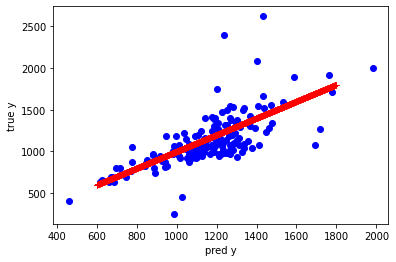

In [6]:
import matplotlib.pyplot as plt 
plt.xlabel("pred y") 
plt.ylabel("true y")

plt.plot(pred_Y * std_test + trend_test,y_test * std_test + trend_test,'bo')
x = np.arange(600,1800) 
y =  x
plt.plot(x,y,'r+')
plt.show()

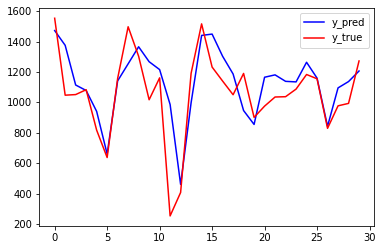

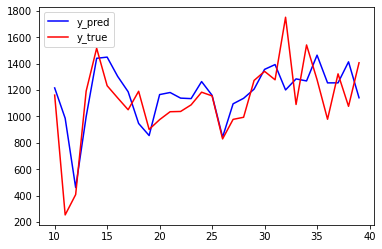

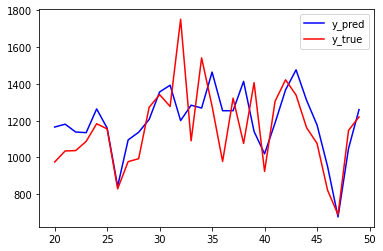

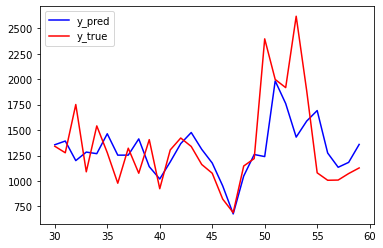

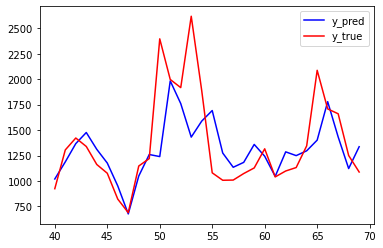

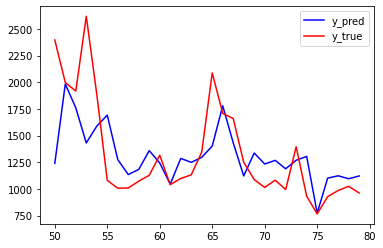

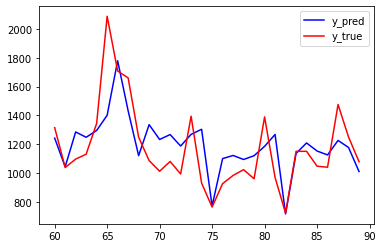

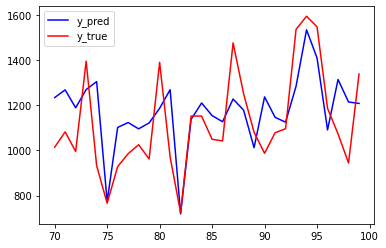

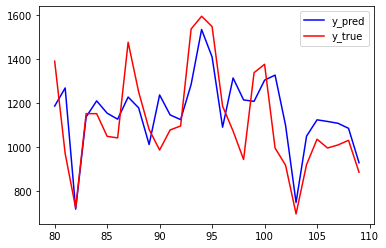

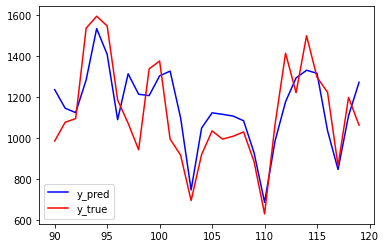

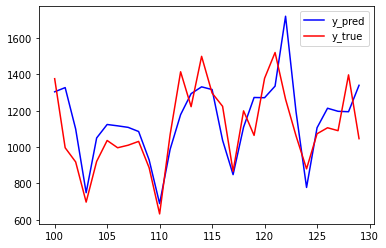

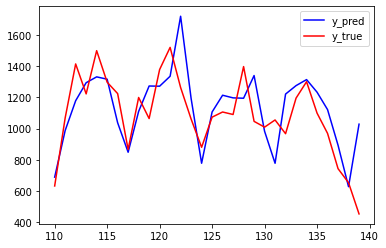

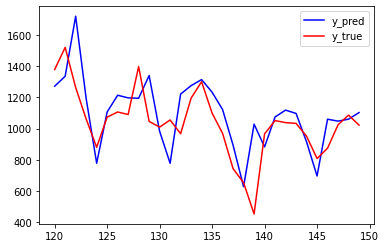

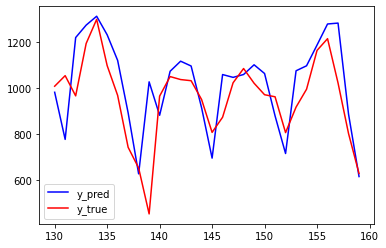

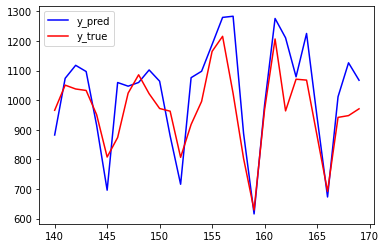

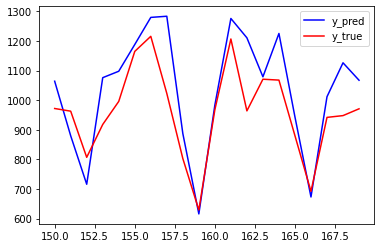

In [7]:
import numpy as np 
import matplotlib.pyplot as plt 

x = np.array(range(len(pred_Y))) 
y_pred = pred_Y * std_test + trend_test
y_true = y_test * std_test + trend_test

for i in range(0,160,10):
    plt.plot(x[i:i+30], y_pred[i:i+30],'b',label = 'y_pred') 
    plt.plot(x[i:i+30], y_true[i:i+30],'r',label = 'y_true') 
    # plt.title('Sine')  
    plt.legend()
    plt.show()